## ECGR 5106 - HW # 6

In [1]:
# Installing the d2l Module
!pip install d2l==1.0.0a1.post0
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.7-py3-none-any.whl size=11093 sha256=400ad958b8e8e73d724c1c958f408786ba920792fcb84613b980da055a464131
  Stored in directory: /root/.cache/pip/wheels/b9/54/3b/f84523431ce82e08462644d279c0e13a51a00236e237e6bc7e
Successfully built ptflops


In [2]:
# Importing all the Necessary Libraries

%matplotlib inline
import math
import pandas as pd
import numpy as np
import ptflops

import matplotlib.pyplot as plt
import torch
import time
import torchvision
import torch.nn.functional as F   
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import torchvision.models as models
from ptflops import get_model_complexity_info

import torch
torch.__version__
torch.cuda.current_device()
torch.cuda.get_device_name(0)

d2l.use_svg_display()

# Code Snippet to Ignore Warning
import warnings
warnings.filterwarnings("ignore")
     

## Problem # 1

For the problem of Machine Learning Translation:

A deeper Transformer will be trained. Its effect on the training speed, model complexity, and translation, both quantitatively, and qualitatively will be compared agaist the baseline model. Results will be plotted and reported.


## Training the Baseline Model

In [3]:
# Downloading the Dataset
class MTFraEng(d2l.DataModule):
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

data = MTFraEng()
raw_text = data._download()

In [4]:
# Preprocessing the Data
@d2l.add_to_class(MTFraEng)
def _preprocess(self, text):
    # Replacing non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Inserting space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)
    
text = data._preprocess(raw_text)

In [5]:
#Tokenizing the Sequences
@d2l.add_to_class(MTFraEng) 
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

src, tgt = data._tokenize(text)

In [6]:
# Defining the Positionwise Feed-Forward Networks
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [7]:
# Adding Residual Connection & Layer Normalization
class AddNorm(nn.Module): 
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [8]:
# Defining the Encoder Logic
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))


class TransformerEncoder(d2l.Encoder): 
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [9]:
# Defining the Decoder Logic
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

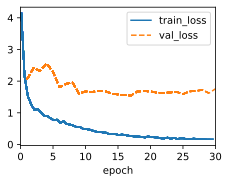

In [22]:
# Training on the Data
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [23]:
# Calculating the Training Time and Model Complexity
print("Training Time (Baseline Transformer Model): ", t1-t0)

Training Time (Baseline Transformer Model):  29.949615001678467


In [25]:
# Using the Transformer Model to Translate English Sentences into French and compute their BLEU scores
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ['je', 'perdu', '.'], bleu,0.687
he's calm . => ['il', 'est', 'calme', '.'], bleu,1.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


## Training a Deeper Transformer Model

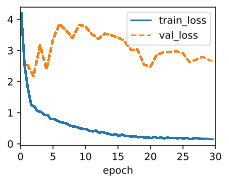

In [13]:
# Training on the Data (For Deeper Model with 4 Transformer Blocks)
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 4, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [14]:
# Calculating the Training Time and Model Complexity
print("Training Time (Deeper Transformer Model (4 Blks)): ", t1-t0)

Training Time (Deeper Transformer Model (4 Blks)):  43.20629405975342


In [15]:
# Using the Transformer Model to Translate English Sentences into French and compute their BLEU scores
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


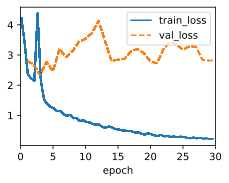

In [16]:
# Training on the Data (For Deeper Model with 6 Transformer Blocks)
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 6, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [17]:
# Calculating the Training Time and Model Complexity
print("Training Time (Deeper Transformer Model (6 Blks)): ", t1-t0)

Training Time (Deeper Transformer Model (6 Blks)):  46.027830839157104


In [18]:
# Using the Transformer Model to Translate English Sentences into French and compute their BLEU scores
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


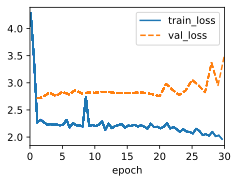

In [19]:
# Training on the Data (For Deeper Model with 8 Transformer Blocks)
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 8, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [20]:
# Calculating the Training Time and Model Complexity
print("Training Time (Deeper Transformer Model (8 Blks)): ", t1-t0)

Training Time (Deeper Transformer Model (8 Blks)):  39.53871965408325


In [21]:
# Using the Transformer Model to Translate English Sentences into French and compute their BLEU scores
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0.000
i lost . => ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0.000
he's calm . => ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0.000
i'm home . => ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0.000


## Problem # 2

For the problem of the Vision Transformer, yet again, a deeper Transformer with more multiheaded self-attention blocks will be trained. Its effect on the training speed, model complexity, and translation, both quantitatively, and qualitatively will be compared agaist the baseline model. Results will be plotted and reported.

## Traing the Baseline Vision Transformer Model

In [14]:
# Defining the Patch Embedding Logic
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

In [15]:
# Defining the Vision Transformer Encoder
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))
        
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

In [16]:
# Putting Everything together for Training using FashionMNIST Dataset
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

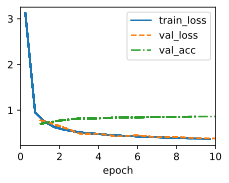

In [17]:
# Training the Baseline Vision Transformer Model on FashionMNIST Dataset
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [18]:
# Calculating the Training Speed
print("Training Time (Baseline Vision Transformer): ", t1 - t0)

Training Time (Baseline Vision Transformer):  324.65189909935


In [20]:
# Calculating the Model Complexity
input_shape = (1, img_size, img_size)  # Assuming RGB images, remove the batch dimension

# Pass the example input through the model to get FLOPs and parameter counts
flops, params = get_model_complexity_info(model, input_shape, as_strings=True, print_per_layer_stat=True)

print(f"Number of FLOPs: {flops}")
print(f"Number of parameters: {params}")

ViT(
  6.44 M, 99.699% Params, 237.76 MMac, 100.000% MACs, 
  (patch_embedding): PatchEmbedding(
    131.58 k, 2.038% Params, 4.74 MMac, 1.992% MACs, 
    (conv): Conv2d(131.58 k, 2.038% Params, 4.74 MMac, 1.992% MACs, 1, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (blks): Sequential(
    6.3 M, 97.566% Params, 233.02 MMac, 98.005% MACs, 
    (0): ViTBlock(
      3.15 M, 48.783% Params, 116.51 MMac, 49.003% MACs, 
      (ln1): LayerNorm(1.02 k, 0.016% Params, 18.94 KMac, 0.008% MACs, (512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        1.05 M, 16.237% Params, 38.8 MMac, 16.318% MACs, 
        (attention): DotProductAttention(
          0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
          (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
        )
        (W_q): Linear(262.14 k, 4.059% Params, 9.7 MMac, 4.079% MACs, in_features=512, 

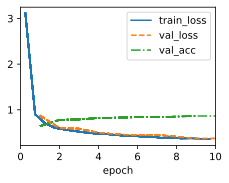

In [21]:
# Training the Deeper Vision Transformer Model on FashionMNIST Dataset (3 Blocks)
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 16, 3
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [22]:
# Calculating the Training Speed
print("Training Time (Vision Transformer (3 Blks)): ", t1 - t0)

Training Time (Vision Transformer (3 Blks)):  471.20379614830017


In [23]:
# Calculating the Model Complexity
input_shape = (1, img_size, img_size)  # Assuming RGB images, remove the batch dimension

# Pass the example input through the model to get FLOPs and parameter counts
flops, params = get_model_complexity_info(model, input_shape, as_strings=True, print_per_layer_stat=True)

print(f"Number of FLOPs: {flops}")
print(f"Number of parameters: {params}")

ViT(
  9.59 M, 99.798% Params, 354.27 MMac, 100.000% MACs, 
  (patch_embedding): PatchEmbedding(
    131.58 k, 1.369% Params, 4.74 MMac, 1.337% MACs, 
    (conv): Conv2d(131.58 k, 1.369% Params, 4.74 MMac, 1.337% MACs, 1, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (blks): Sequential(
    9.45 M, 98.364% Params, 349.52 MMac, 98.661% MACs, 
    (0): ViTBlock(
      3.15 M, 32.788% Params, 116.51 MMac, 32.887% MACs, 
      (ln1): LayerNorm(1.02 k, 0.011% Params, 18.94 KMac, 0.005% MACs, (512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        1.05 M, 10.913% Params, 38.8 MMac, 10.951% MACs, 
        (attention): DotProductAttention(
          0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
          (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
        )
        (W_q): Linear(262.14 k, 2.728% Params, 9.7 MMac, 2.738% MACs, in_features=512,

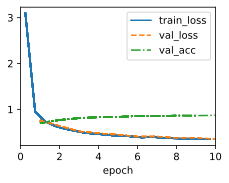

In [24]:
# Training the Deeper Vision Transformer Model on FashionMNIST Dataset (6 Blocks)
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 16, 6
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
t0 = time.time()
trainer.fit(model, data)
t1 = time.time()

In [25]:
# Calculating the Training Speed
print("Training Time (Vision Transformer (6 Blks)): ", t1 - t0)

Training Time (Vision Transformer (6 Blks)):  904.2825357913971


In [26]:
# Calculating the Model Complexity
input_shape = (1, img_size, img_size)  # Assuming RGB images, remove the batch dimension

# Pass the example input through the model to get FLOPs and parameter counts
flops, params = get_model_complexity_info(model, input_shape, as_strings=True, print_per_layer_stat=True)

print(f"Number of FLOPs: {flops}")
print(f"Number of parameters: {params}")

ViT(
  19.04 M, 99.898% Params, 703.79 MMac, 100.000% MACs, 
  (patch_embedding): PatchEmbedding(
    131.58 k, 0.690% Params, 4.74 MMac, 0.673% MACs, 
    (conv): Conv2d(131.58 k, 0.690% Params, 4.74 MMac, 0.673% MACs, 1, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (blks): Sequential(
    18.9 M, 99.175% Params, 699.05 MMac, 99.326% MACs, 
    (0): ViTBlock(
      3.15 M, 16.529% Params, 116.51 MMac, 16.554% MACs, 
      (ln1): LayerNorm(1.02 k, 0.005% Params, 18.94 KMac, 0.003% MACs, (512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        1.05 M, 5.502% Params, 38.8 MMac, 5.513% MACs, 
        (attention): DotProductAttention(
          0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
          (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
        )
        (W_q): Linear(262.14 k, 1.375% Params, 9.7 MMac, 1.378% MACs, in_features=512, 